In [3]:
import numpy as np
from scipy import linalg, special, sparse
import sympy
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import cvxpy as cp
import copy
import requests
import xmltodict


sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

# Import new simulation output

In [4]:
time = '10'
date = '2023-03-08'
experiment = 'balance-fix'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [5]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [6]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [7]:
stoichiometry = agent['ecoli-metabolism'].model.stoichiometry
maintenance_reaction = agent['ecoli-metabolism'].model.maintenance_reaction
stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8"] # generate carbon mistake in parca, efflux/influx proton gen, iron cheating
for rxn in bad_rxns:
    stoichiometry.pop(rxn, None)


Pandas automatically understands dicts of dicts as matrices. 

# Import old sim output

In [14]:
experiment = 'balance'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

output_old = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output_old = output_old['agents']['0']
fba_old = output_old['listeners']['fba_results']
mass_old = output_old['listeners']['mass']
bulk_old = pd.DataFrame(output_old['bulk'])

exchanges_old = pd.DataFrame(fba_old["estimated_exchange_dmdt"])
homeostatic_old = pd.DataFrame(fba_old["target_homeostatic_dmdt"])
maintenance_old = pd.DataFrame(fba_old["target_maintenance_flux"])

# Run new FBA

In [15]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set(
    [
        # "D-Ribopyranose[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
    ]
)
removals = set(
                [
               #    "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
                ]
                )


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'GLC[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

In [16]:
Sd = pd.DataFrame(stoichiometry, dtype=np.int8).fillna(0).astype(np.int8)


In [17]:
#stoich_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}

mets_df = pd.DataFrame(Sd.index, columns=["Name"]) # index to name
rxns_df = pd.DataFrame(Sd.columns, columns=["Name"]) 

exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"])
maintenance = pd.DataFrame(fba["target_maintenance_flux"])

kinetic = pd.DataFrame(fba["target_kinetic_fluxes"])
kin_rxns = list(kinetic.keys())

homeostatic_mets = list(homeostatic.keys())
exchange_mets = list(exchanges.keys())
intermediate_mets = list(set(mets_df["Name"]) - set(homeostatic.keys()))

n_mets, n_orig_rxns = Sd.shape

exchange_mets.extend(list(uptake))

Se = pd.DataFrame(index=Sd.index)

for met in exchange_mets:
    exch_name = met + " exchange"
    if met in uptake:
        Se[exch_name] = np.zeros(n_mets).astype(np.int8)
        Se.at[met, exch_name] = 1
    
    Se[exch_name + " rev"] = np.zeros(n_mets).astype(np.int8)
    Se.at[met, exch_name + " rev"] = -1
      
    
    
S_orig = np.array(Sd, dtype=np.float64)
S_exch = np.array(Se, dtype=np.float64)

_, n_exch_rxns = S_exch.shape


int_df = mets_df[mets_df['Name'].isin(intermediate_mets)].reset_index()
int_idx = list(int_df["index"])

hom_df = mets_df[mets_df['Name'].isin(homeostatic_mets)].reset_index()
target_hom = pd.DataFrame(homeostatic.loc[4, :]).reset_index(drop=False)
target_hom.columns = ["Name", "Count"]
merge_df = hom_df.set_index('Name').join(target_hom.set_index('Name'))

kin_df = rxns_df[rxns_df['Name'].isin(kin_rxns)].reset_index()
target_kin = pd.DataFrame(kinetic.loc[4, :]).reset_index(drop=False)
target_kin.columns = ["Name", "Flux"]
merge_kin_df = kin_df.set_index('Name').join(target_kin.set_index('Name'))

v_hom = np.array(merge_df["Count"]).astype(np.float64)
hom_idx = np.array(merge_df["index"]).astype(np.int64)

v_kin = np.array(merge_kin_df["Flux"]).astype(np.float64)
kin_idx = np.array(merge_kin_df["index"]).astype(np.int64)

v_main = np.array(fba["target_maintenance_flux"][4])
main_idx = list(Sd.columns).index("maintenance_reaction")


secretion_idx = np.where(S_exch.sum(axis=0) == -1)[0]

In [18]:
v = cp.Variable(n_orig_rxns)
e = cp.Variable(n_exch_rxns)
v_t = cp.hstack([v,e])
dm = S_orig @ v + S_exch @ e 


constr = []
constr.append(dm[int_idx] == 0)
constr.append(v[main_idx] == v_main)
# constr.append(dm[hom_idx] == v_hom)
constr.extend([v >= 0, v <= 100000000, e >= 0, e <= 100000000])

loss = 0
loss += cp.norm1(dm[hom_idx] - v_hom)
loss += 0.001*(cp.sum(e[secretion_idx]))
loss += 0.00001*(cp.sum(v))
loss += 0.000001 * cp.norm1(v[kin_idx] - v_kin)

In [19]:
p = cp.Problem(
        cp.Minimize(loss),
    constr
    )
               
p.solve(solver=cp.GLOP, verbose=False)

1408.8400771785082

# Analyze output

In [36]:
exchange_rxns = Se.columns
exchange_nb = pd.DataFrame({exchange_rxns[i]: [e.value[i]] for i in range(len(exchange_rxns))}).sort_values(by=0, axis=1, ascending=False).T
exchange_nb = exchange_nb[exchange_nb[0] != 0]
index_raw = list(exchange_nb.index.str.split())
index_cleaned = [index_raw[i][0] for i in range(len(index_raw))]
exchange_nb.index = index_cleaned
exchange_nb.columns = ["Exchange flux new"]
exchange_nb.head(5)

,Exchange flux new
WATER[p],4.493609e+06
CARBON-DIOXIDE[p],1.006485e+06
AMMONIUM[c],8.870805e+05
OXYGEN-MOLECULE[p],8.661753e+05
GLC[p],7.532153e+05


In [37]:
exchange_sim = pd.DataFrame(exchanges.loc[4, :].abs().sort_values())
exchange_sim = exchange_sim[exchange_sim[4] != 0]
exchange_sim.columns = ["Exchange flux"]
exchange_sim.tail(5)

,Exchange flux
AMMONIUM[c],887279
GLC[p],897920
OXYGEN-MOLECULE[p],1733230
CARBON-DIOXIDE[p],1873581
WATER[p],3625912


In [38]:
exchange_sim_old = pd.DataFrame(exchanges_old.loc[4, :].abs().sort_values())
exchange_sim_old = exchange_sim_old[exchange_sim_old[4] != 0]
exchange_sim_old.columns = ["Exchange flux"]
exchange_sim_old.tail(5)

,Exchange flux
CARBON-DIOXIDE[p],141357
GLC[p],609059
PROTON[p],775052
AMMONIUM[c],887278
WATER[p],5357497


In [40]:
exch_comp = pd.merge(exchange_sim_old, exchange_sim, left_index=True, right_index=True, suffixes=(' old', ' fixed'), how='outer').fillna(0).astype(np.int64)
exch_comp = pd.merge(exchange_nb, exch_comp, left_index=True, right_index=True, suffixes=(' new', ' sim'), how='outer').fillna(0).astype(np.int64)
exch_comp.sort_values(by="Exchange flux new", ascending=False).head()

,Exchange flux new,Exchange flux old,Exchange flux fixed
WATER[p],4493608,5357497,3625912
CARBON-DIOXIDE[p],1006485,141357,1873581
AMMONIUM[c],887080,887278,887279
OXYGEN-MOLECULE[p],866175,1329,1733230
GLC[p],753215,609059,897920


Text(850000, 2000, 'oxygen')

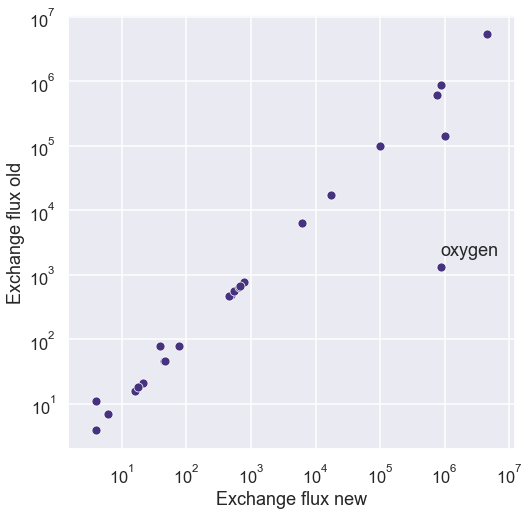

In [71]:
plt.figure(figsize=[8,8])

sns.scatterplot(x="Exchange flux new", y="Exchange flux old", data=exch_comp)
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')
plt.text(850000, 2000, "oxygen")

Text(100000, 2000000, 'oxygen')

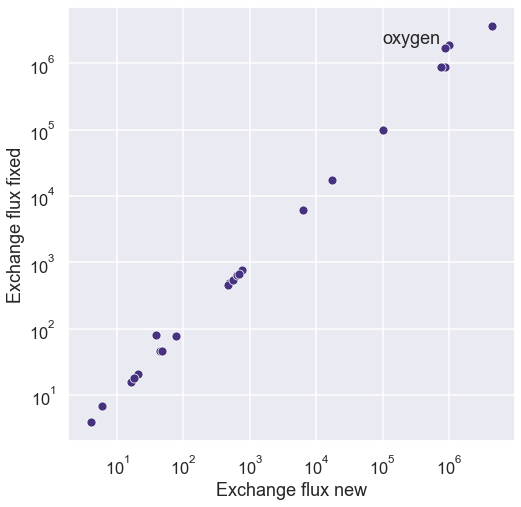

In [76]:
plt.figure(figsize=[8,8])

sns.scatterplot(x="Exchange flux new", y="Exchange flux fixed", data=exch_comp)
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')
plt.text(100000, 2000000, "oxygen")

In [43]:
flux_indexed = list(Sd.columns[:n_orig_rxns])
fluxes = pd.DataFrame({flux_indexed[i]: [v.value[i], stoichiometry[flux_indexed[i]]] for i in range(len(flux_indexed))}).T
fluxes.sort_values(by=0, axis=0, ascending=False).head(15)

,0,1
TRANS-RXN-145,4493608.956661,"{'WATER[p]': -1, 'WATER[c]': 1}"
ATPSYN-RXN (reverse),3189029.242245,"{'ATP[c]': 1, 'WATER[c]': 1, 'PROTON[c]': 3, '..."
maintenance_reaction,1898967.604471,"{'ATP[c]': -1, 'WATER[c]': -1, 'ADP[c]': 1, 'P..."
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.,1487950.905566,"{'NADH[c]': -1, 'UBIQUINONE-8[i]': -1, 'PROTON..."
GAPOXNPHOSPHN-RXN,1250954.681113,"{'GAP[c]': -1, 'NAD[c]': -1, 'Pi[c]': -1, 'DPG..."
PHOSGLYPHOS-RXN (reverse),1250952.681113,"{'G3P[c]': 1, 'ATP[c]': 1, 'DPG[c]': -1, 'ADP[..."
3PGAREARR-RXN (reverse),1120153.681113,"{'2-PG[c]': 1, 'G3P[c]': -1}"
2PGADEHYDRAT-RXN,1120137.681113,"{'2-PG[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': 1,..."
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),1006485.043339,"{'CARBON-DIOXIDE[p]': 1, 'CARBON-DIOXIDE[c]': -1}"
TRANS-RXN0-474,866158.293339,"{'OXYGEN-MOLECULE[p]': -1, 'OXYGEN-MOLECULE[c]..."


In [67]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.columns = ["Flux"]

sim_fluxes_old = pd.DataFrame(fba_old["estimated_fluxes"])
sim_fluxes_old = pd.DataFrame(sim_fluxes_old.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes_old.columns = ["Flux old (counts)"]
sim_fluxes_old

,Flux old (counts)
TRANS-RXN-121,8204553
TRANS-RXN-300,8204553
ATPSYN-RXN (reverse),1954487
TRANS-RXN-145,1337389
FUMHYDR-RXN__FUMARASE-A,510573
...,...
RXN0-1441,0
RXN0-1401 (reverse),0
RXN0-1401,0
RXN0-14,0


<AxesSubplot:xlabel='Flux old (counts)', ylabel='index'>

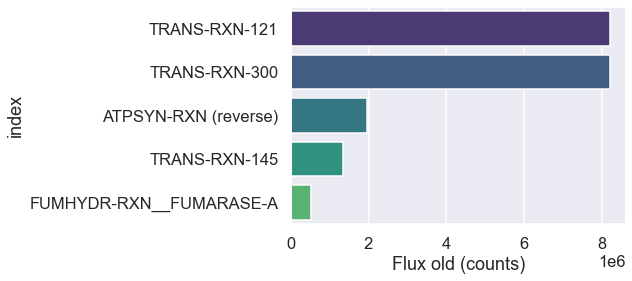

In [69]:
d = sim_fluxes_old.head(5).reset_index()
sns.barplot(y="index", x="Flux old (counts)", data=d)

In [78]:
dmdt_indexed = list(Sd.index)
# hom_idx
dmdt_dict = {dmdt_indexed[i]: [dm.value[i], v_hom[j]] for j, i in enumerate(hom_idx)}
dmdt = pd.DataFrame(dmdt_dict).sort_values(by=0, axis=1).T
dmdt.columns = ["Homeostatic target", "Homeostatic estimate"]
dmdt
#dmdt = pd.DataFrame({dmdt_indexed[i]: [dm.value[i], v_hom[j]] for j, i in enumerate(hom_idx)})
#dmdt.sort_values(by=0, axis=1, ascending=False).T.head(20)

,Homeostatic target,Homeostatic estimate
PPI[c],-78147.0,-78147.0
PROTON[c],-17999.0,-17999.0
GMP[c],-4851.0,-4851.0
AMP[c],-4531.0,-4531.0
CMP[c],-4307.0,-4307.0
...,...,...
VAL[c],34446.0,34446.0
GLY[c],34610.0,34610.0
LEU[c],36085.0,36085.0
L-ALPHA-ALANINE[c],43678.0,43678.0


(0.1, 100000000)

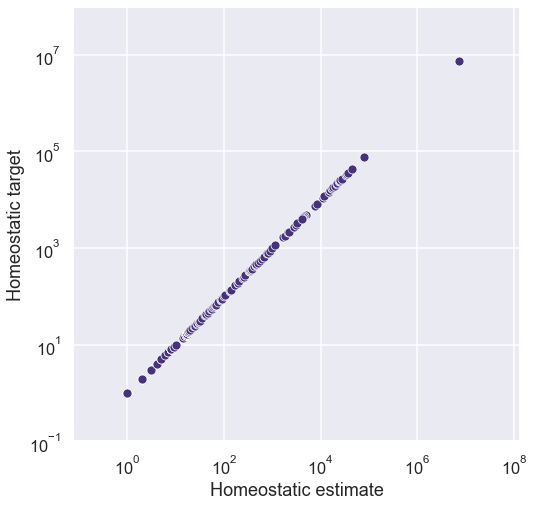

In [87]:
plt.figure(figsize=[8,8])

sns.scatterplot(x="Homeostatic estimate", y="Homeostatic target", data=dmdt.abs())
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1,10**8)
plt.ylim(0.1,10**8)
#plt.text(100000, 2000000, "oxygen")

# How do the fixed kinetics look?

In [124]:
pd.DataFrame(fba['target_kinetic_bounds'])

,1.1.1.39-RXN,1.1.1.83-RXN,1.13.11.16-RXN,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18362//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18367//CPD-18371/ADENOSYL-HOMO-CYS/PROTON.67.,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18369//CPD-18372/ADENOSYL-HOMO-CYS/PROTON.67.,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18392//CPD-18405/ADENOSYL-HOMO-CYS/PROTON.67.,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18403//CPD-18404/ADENOSYL-HOMO-CYS/PROTON.67.,...,UDPGLUCEPIM-RXN (reverse),UDPHYDROXYMYRGLUCOSAMNACETYLTRANS-RXN,UDPNACETYLGLUCOSAMACYLTRANS-RXN,UDPNACETYLGLUCOSAMENOLPYRTRANS-RXN,UGD-RXN,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,URA-PHOSPH-RXN,UROGENIIISYN-RXN,URPHOS-RXN__URPHOS-CPLX,XYLULOKIN-RXN
0,"[17723, 17723]","[490, 490]","[0, 66]","[2085, 6016]","[9, 1253]","[9, 1253]","[9, 1253]","[9, 1253]","[9, 1253]","[9, 1253]",...,"[0, 312537]","[0, 2005]","[560, 820]","[127, 7754]","[0, 129]","[120, 120]","[0, 3779]","[0, 25271]","[36429, 36429]","[2884, 2884]"
1,"[17722, 17722]","[490, 490]","[0, 66]","[2085, 6016]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]",...,"[0, 312537]","[0, 2005]","[560, 820]","[127, 7754]","[0, 129]","[120, 120]","[0, 3779]","[0, 25271]","[36429, 36429]","[2884, 2884]"
2,"[17722, 17722]","[490, 490]","[0, 66]","[2085, 6016]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]",...,"[0, 312537]","[0, 2005]","[560, 820]","[127, 7754]","[0, 129]","[120, 120]","[0, 3779]","[0, 25271]","[36429, 36429]","[2884, 2884]"
3,"[17721, 17721]","[490, 490]","[0, 66]","[2085, 6016]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]","[9, 1259]",...,"[0, 312537]","[0, 2012]","[560, 820]","[127, 7754]","[0, 129]","[120, 120]","[0, 3779]","[0, 25271]","[36646, 36646]","[2884, 2884]"
4,"[17721, 17721]","[490, 490]","[0, 66]","[2085, 6016]","[9, 1263]","[9, 1263]","[9, 1263]","[9, 1263]","[9, 1263]","[9, 1263]",...,"[0, 312537]","[0, 2012]","[560, 820]","[127, 7754]","[0, 129]","[120, 120]","[0, 3779]","[0, 25271]","[36646, 36646]","[2884, 2884]"


In [153]:
df1 = pd.DataFrame(fba['target_kinetic_fluxes']).T.loc[:,4]
df1 = pd.DataFrame(df1)
df1.columns=["Target kinetic flux"]

df2 = pd.DataFrame(fba['target_kinetic_bounds']).T.loc[:, 4]
df2 = pd.DataFrame(df2)
df2.columns = ["Bounds"]
df2 = pd.DataFrame(df2["Bounds"].tolist(),  index = df2.index, columns=['Lower kinetic bound','Upper kinetic bound'])

df1 = pd.merge(df1, df2, left_index=True, right_index=True, how='inner').fillna(0).astype(np.int64)
df1["New fluxes"] = fluxes.loc[df1.index, 0]

df2 = pd.DataFrame(fba['estimated_fluxes']).T.loc[:,4]
df2 = pd.DataFrame(df2)
df1["Fixed fluxes"] = df2.loc[df1.index, :]

df2 = pd.DataFrame(fba_old['estimated_fluxes']).T.loc[:,4]
df2 = pd.DataFrame(df2)
df1["Old fluxes"] = df2.loc[df1.index, :]
df1

,Target kinetic flux,Lower kinetic bound,Upper kinetic bound,New fluxes,Fixed fluxes,Old fluxes
1.1.1.39-RXN,17721,17721,17721,-0.0,0,0
1.1.1.83-RXN,490,490,490,-0.0,0,0
1.13.11.16-RXN,33,0,66,0.0,0,0
1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),3367,2085,6016,-0.0,1683,1683
2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,314,9,1263,-0.0,0,0
...,...,...,...,...,...,...
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,120,120,120,120.0,60,60
URA-PHOSPH-RXN,1889,0,3779,-0.0,0,0
UROGENIIISYN-RXN,12635,0,25271,37.0,9,9
URPHOS-RXN__URPHOS-CPLX,36646,36646,36646,-0.0,18323,18323


In [166]:
df1.sort_values(by="Lower kinetic bound")

,Target kinetic flux,Lower kinetic bound,Upper kinetic bound,New fluxes,Fixed fluxes,Old fluxes
ISOCHORSYN-RXN__ENTC-MONOMER (reverse),2113,0,4226,-0.0,1056,1056
RXN0-6708,9005,0,18011,-0.0,0,0
PREPHENATEDEHYDRAT-RXN,13393,0,30622,14720.0,3680,3680
PRAISOM-RXN,25916,0,66776,4045.0,1011,1011
PPPGPPHYDRO-RXN,0,0,1,0.0,0,0
...,...,...,...,...,...,...
ISOCITDEH-RXN,777049,646436,919616,162080.0,83337,24716
FUMHYDR-RXN__FUMARASE-A (reverse),742291,742291,742291,-0.0,371145,371145
INORGPYROPHOSPHAT-RXN[CCO-CYTOSOL]-PPI/WATER//Pi/PROTON.34.,1580151,866345,1824739,302811.0,78675,80760
FUMHYDR-RXN__FUMARASE-A,1021147,1021147,1021147,-0.0,449687,510573


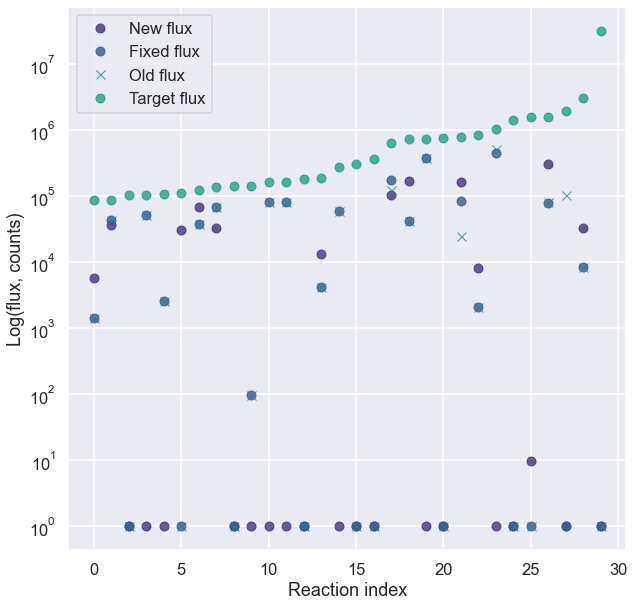

In [194]:
ranges = np.array(df1.loc[:, ["Lower kinetic bound","Upper kinetic bound"]])
ranges[ranges == 0] = 1
mid_dist = np.array([np.mean(ranges, axis=1), (ranges[:, 1] - ranges[:, 0])/2]).T

new_fluxes = np.array(df1["New fluxes"])
fixed_fluxes = np.array(df1["Fixed fluxes"])
old_fluxes = np.array(df1["Old fluxes"])
target_fluxes = np.array(df1["Target kinetic flux"])
index = np.array(df1.index)

sort_index = target_fluxes.argsort()
sorted_new = new_fluxes[sort_index][-30:] + 1
sorted_old = old_fluxes[sort_index][-30:] + 1
sorted_fixed = fixed_fluxes[sort_index][-30:] + 1
sorted_target = target_fluxes[sort_index][-30:] + 1
sorted_bars = mid_dist[sort_index,:][-30:]
sorted_index = index[sort_index][-30:]


f, ax = plt.subplots(figsize=[10,10])


# ax.errorbar(np.arange(0, len(sorted_old)), sorted_bars[:, 0],  yerr=sorted_bars[:, 1], linestyle="none", label="Target flux")
#ax.plot(np.arange(0, len(sorted_target)), sorted_target, linestyle="none", marker='o', alpha=0.5, label="Target")
ax.plot(np.arange(0, len(sorted_new)), sorted_new, linestyle="none", marker='o', alpha=0.8, label="New flux")
ax.plot(np.arange(0, len(sorted_fixed)), sorted_fixed, linestyle="none", marker='o', alpha=0.8, label="Fixed flux")
ax.plot(np.arange(0, len(sorted_old)), sorted_old, linestyle="none", marker='x', alpha=0.8, label="Old flux")
ax.plot(np.arange(0, len(sorted_old)), sorted_target, linestyle="none", marker='o', alpha=0.8, label="Target flux")


plt.yscale('log')

plt.legend()
plt.xlabel('Reaction index')
plt.ylabel('Log(flux, counts)')

plt.show()

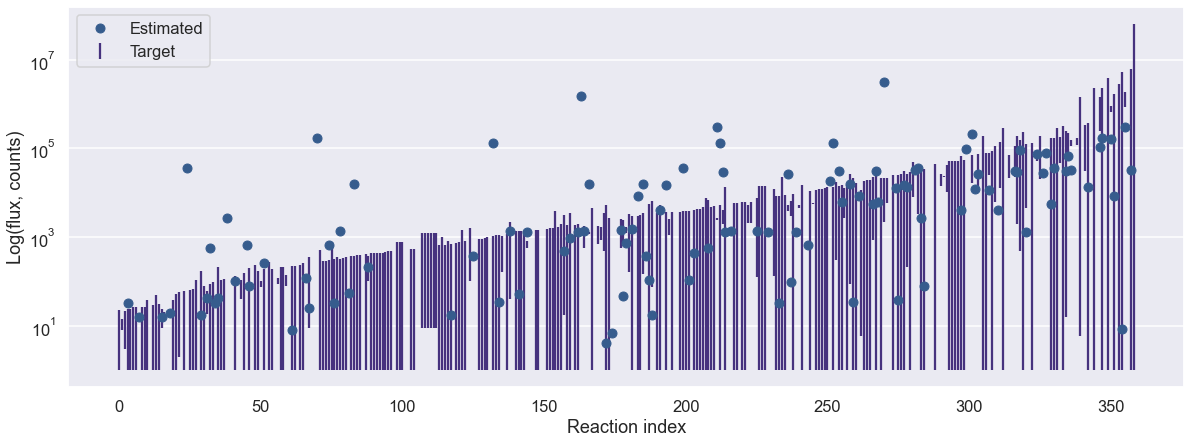

In [187]:
sorted_top_fluxes = sorted_new[sorted_bars[:,0] > 10]
sorted_top_bars = sorted_bars[sorted_bars[:,0] > 10]
sorted_top_index = sorted_index[sorted_bars[:,0] > 10]

f, ax = plt.subplots(figsize=[20,7])

ax.errorbar(np.arange(0, len(sorted_top_fluxes)), sorted_top_bars[:, 0],  yerr=sorted_top_bars[:, 1], linestyle="none", label="Target")
ax.plot(np.arange(0, len(sorted_top_fluxes)), sorted_top_fluxes, linestyle="none", marker='o', label="Estimated")

plt.legend()
plt.xlabel('Reaction index')
plt.ylabel('Log(flux, counts)')
#plt.xticks(np.arange(0, len(sorted_top_fluxes), 1.0), labels=list(sorted_top_index), rotation=90)
plt.grid(axis='x')
plt.yscale('log')

plt.show()

NameError: name 'sorted_top_fluxes_c' is not defined

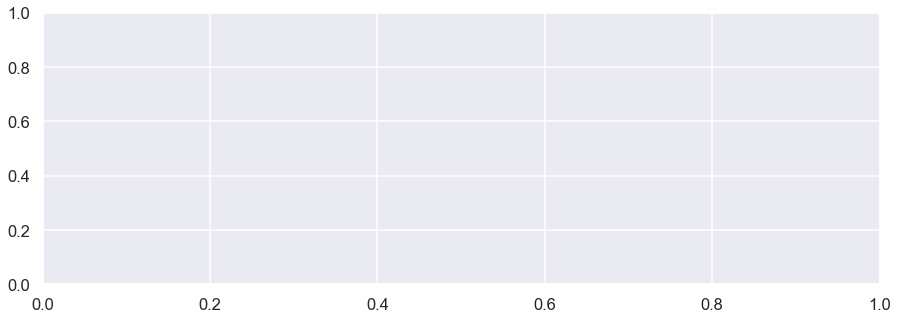

In [ ]:
# sorted_top_fluxes_c = copy.deepcopy(sorted_fluxes[sorted_bars[:,0] > 10])
# sorted_top_bars_c = copy.deepcopy(sorted_bars[sorted_bars[:,0] > 10])
# sorted_top_index_c = copy.deepcopy(sorted_index[sorted_bars[:,0] > 10])

f, ax = plt.subplots(figsize=[15,5])

ax.errorbar(np.arange(0, len(sorted_top_fluxes_c)), sorted_top_bars_c[:, 0],  yerr=sorted_top_bars_c[:, 1], linestyle="none", label="Target flux")
ax.plot(np.arange(0, len(sorted_top_fluxes_c)), sorted_top_fluxes_c, linestyle="none", marker='o', color='darkred',alpha=0.5, label="Cheating flux")
ax.plot(np.arange(0, len(sorted_top_fluxes)), sorted_top_fluxes, linestyle="none", marker='o', color='b',alpha=0.5, label="Estimated flux")


plt.xlabel('Reaction index')
plt.ylabel('Log(flux, counts)')
plt.grid(axis='x')
plt.legend()

plt.show()

# How do the fixed kinetics look?

In [ ]:
df1 = pd.DataFrame(fba['target_kinetic_fluxes'])
df1 = df1.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')

df4 = pd.DataFrame(fba['target_kinetic_bounds'])
df4 = df4.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')
df4 = pd.DataFrame(df4["target"].to_list(), columns=['lower', 'upper'])

df1 = df1.merge(df4, left_index=True, right_index=True)

kinetic_rxns = list(fba['target_kinetic_fluxes'].keys())
df2 = pd.DataFrame(fba['estimated_fluxes']).loc[:, kinetic_rxns]
df2 = df2.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='update')

df3 = df1.merge(df2, left_on=['index', 'timestep'], right_on=['index', 'timestep'])

df3 = df3[df3["timestep"] == 4].sort_values(by="target", ascending=True).reset_index(drop=True)

for column in ["update", "target", "lower", "upper"]:
    df3[column] = df3[column].abs()
    df3[column] = np.log(df3[column])
    
df3 = df3.replace([np.inf, -np.inf], 0)
df3.tail(20)

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,timestep,target,lower,upper,update
409,INOPHOSPHOR-RXN__DEOD-CPLX,4,11.994314,1.791759,14.164120,11.301167
410,RIB5PISOM-RXN__RIB5PISOMA-CPLX,4,11.994771,11.994771,11.994771,11.301624
411,7-ALPHA-HYDROXYSTEROID-DEH-RXN,4,12.108554,10.321112,12.714296,0.000000
412,GLYCEROL-KIN-RXN,4,12.153974,0.000000,12.847121,8.343316
413,DIHYDROOROT-RXN,4,12.521828,12.521828,12.521828,10.986224
414,RXN-8667,4,12.620256,0.000000,14.668222,0.000000
415,ATPSYN-RXN,4,12.807675,12.807675,12.807675,0.000000
416,ASPAMINOTRANS-RXN,4,13.364779,12.395916,14.181992,12.058199
417,MALONYL-COA-ACP-TRANSACYL-RXN,4,13.498475,0.000000,14.625717,10.646971
418,FUMHYDR-RXN__FUMARASE-A (reverse),4,13.517497,13.517497,13.517497,12.824348


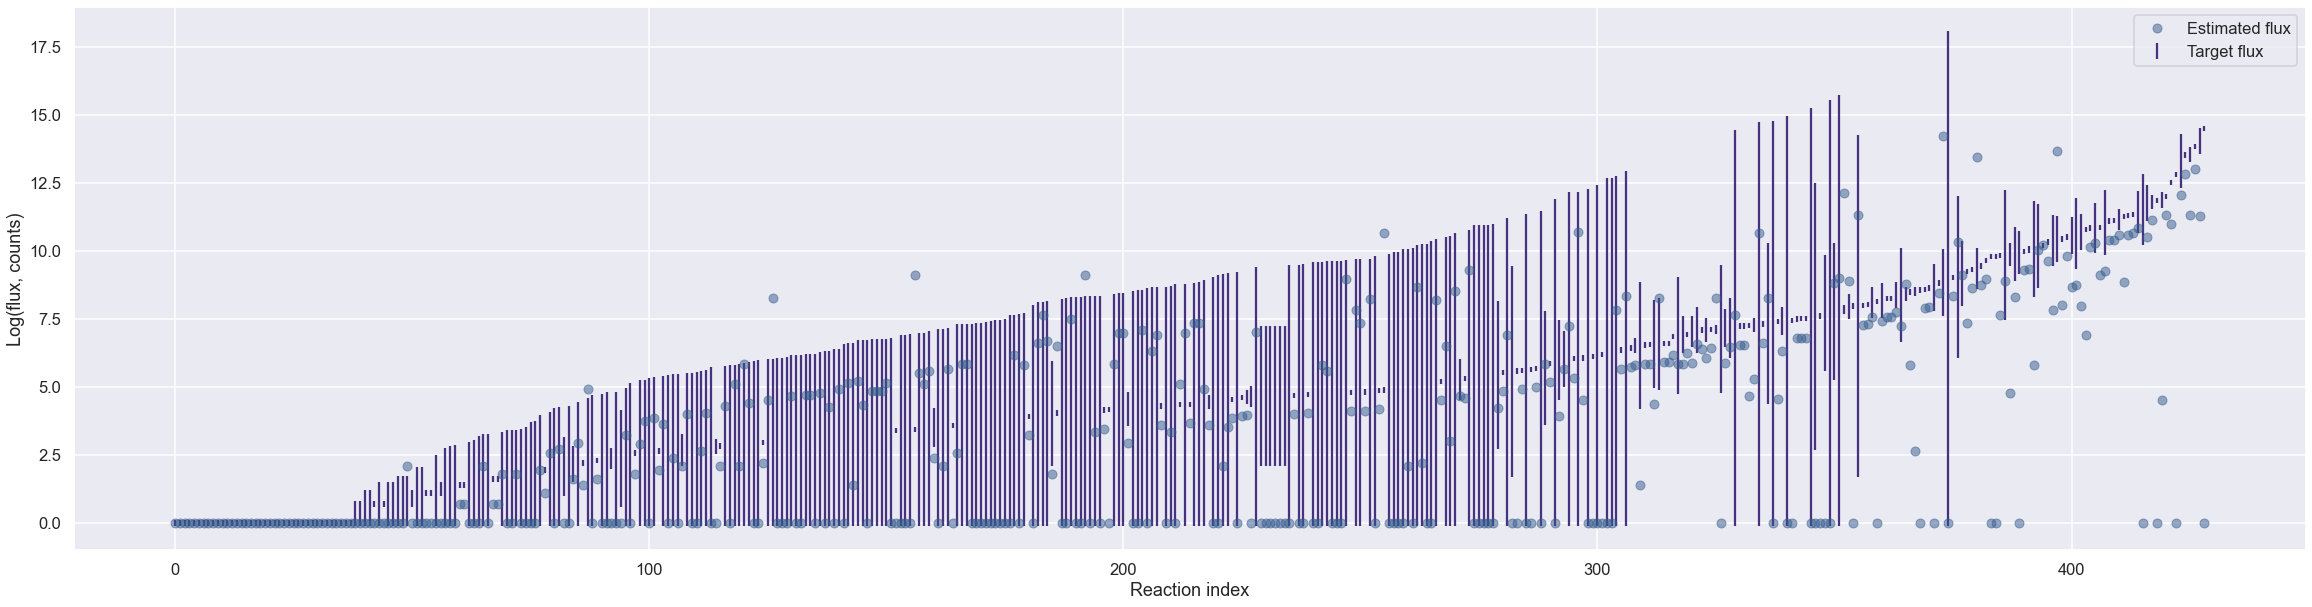

In [ ]:
ranges = np.array(df3.loc[:, ["lower","upper"]])
mid_dist = np.array([np.mean(ranges, axis=1), (ranges[:, 1] - ranges[:, 0])/2 + 0.1]).T

actual_flux = np.array(df3["update"])
index = np.array(df3["index"])

sort_index = mid_dist[:, 0].argsort()
sorted_fluxes = actual_flux[sort_index]
sorted_bars = mid_dist[sort_index,:]
sorted_index = index[sort_index]

sorted_fluxes[sorted_fluxes > 0] = sorted_fluxes[sorted_fluxes > 0]

f, ax = plt.subplots(figsize=[40,10])


ax.errorbar(np.arange(0, len(sorted_fluxes)), sorted_bars[:, 0],  yerr=sorted_bars[:, 1], linestyle="none", label="Target flux")
ax.plot(np.arange(0, len(sorted_fluxes)), sorted_fluxes, linestyle="none", marker='o', alpha=0.5, label="Estimated flux")

plt.legend()
plt.xlabel('Reaction index')
plt.ylabel('Log(flux, counts)')

plt.show()

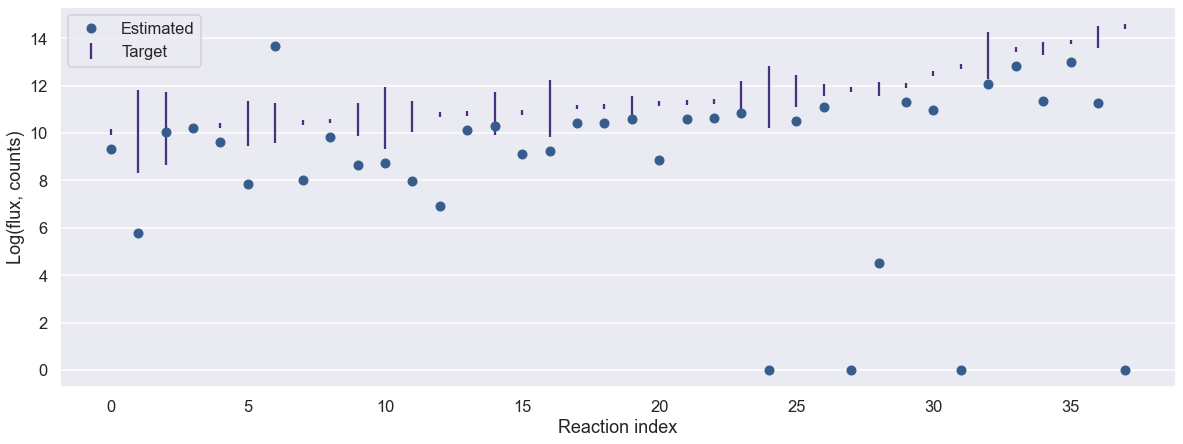

In [64]:
sorted_top_fluxes = sorted_fluxes[sorted_bars[:,0] > 10]
sorted_top_bars = sorted_bars[sorted_bars[:,0] > 10]
sorted_top_index = sorted_index[sorted_bars[:,0] > 10]

f, ax = plt.subplots(figsize=[20,7])

ax.errorbar(np.arange(0, len(sorted_top_fluxes)), sorted_top_bars[:, 0],  yerr=sorted_top_bars[:, 1], linestyle="none", label="Target")
ax.plot(np.arange(0, len(sorted_top_fluxes)), sorted_top_fluxes, linestyle="none", marker='o', label="Estimated")

plt.legend()
plt.xlabel('Reaction index')
plt.ylabel('Log(flux, counts)')
#plt.xticks(np.arange(0, len(sorted_top_fluxes), 1.0), labels=list(sorted_top_index), rotation=90)
plt.grid(axis='x')

plt.show()

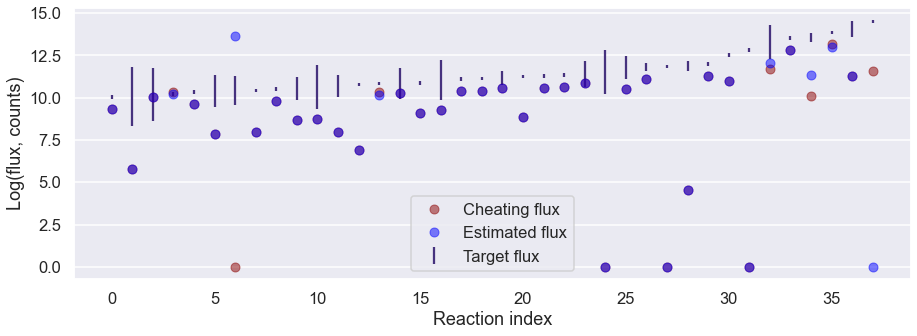

In [66]:
# sorted_top_fluxes_c = copy.deepcopy(sorted_fluxes[sorted_bars[:,0] > 10])
# sorted_top_bars_c = copy.deepcopy(sorted_bars[sorted_bars[:,0] > 10])
# sorted_top_index_c = copy.deepcopy(sorted_index[sorted_bars[:,0] > 10])

f, ax = plt.subplots(figsize=[15,5])

ax.errorbar(np.arange(0, len(sorted_top_fluxes_c)), sorted_top_bars_c[:, 0],  yerr=sorted_top_bars_c[:, 1], linestyle="none", label="Target flux")
ax.plot(np.arange(0, len(sorted_top_fluxes_c)), sorted_top_fluxes_c, linestyle="none", marker='o', color='darkred',alpha=0.5, label="Cheating flux")
ax.plot(np.arange(0, len(sorted_top_fluxes)), sorted_top_fluxes, linestyle="none", marker='o', color='b',alpha=0.5, label="Estimated flux")


plt.xlabel('Reaction index')
plt.ylabel('Log(flux, counts)')
plt.grid(axis='x')
plt.legend()

plt.show()

# Troubleshoot wrong fluxes

In [195]:
top_wrong = fluxes_wrong.sort_values(by=0, axis=1, ascending=False).T.head(50)
top_right = fluxes.sort_values(by=0, axis=1, ascending=False).T.head(50)

top_wrong.join(top_right, lsuffix="wrong", rsuffix="right")

NameError: name 'fluxes_wrong' is not defined

In [196]:
m2 = []

for rxn in ["LXULRU5P-RXN (reverse)", "RXN-21400", "RXN0-703 (reverse)", "RXN0-704", "RIBULPEPIM-RXN__EG12287-MONOMER", "RXN0-705__EG12285-MONOMER"]:
    m2.append({key: 2*value for key, value in stoichiometry[rxn].items()})
    
pd.DataFrame(m2, dtype=np.int8).fillna(0).astype(np.int8).sum(axis=0)

L-RIBULOSE-5-P[c]          0
L-XYLULOSE-5-P[c]          0
L-DEHYDRO-ASCORBATE[c]    -2
WATER[c]                  -2
CPD-334[c]                 0
3-KETO-L-GULONATE[c]       0
NAD[c]                     2
NADH[c]                   -2
PROTON[c]                 -2
ATP[c]                    -2
CPD-2343[c]                0
ADP[c]                     2
XYLULOSE-5-PHOSPHATE[c]    2
CARBON-DIOXIDE[c]          2
dtype: int64

In [197]:
m1 = []

for rxn in ["ALANINE-AMINOTRANSFERASE-RXN (reverse)", "MALATE-DEH-RXN (reverse)", "RXN-3523", "RXN-10981", \
 "RXN-12440", "CHD-RXN (reverse)", "RXN0-7230-CHOLINE/UBIQUINONE-8//BETAINE_ALDEHYDE/CPD-9956.48.", "ALARACECAT-RXN", "PMPOXI-RXN", "RXN0-5240"]:
    m1.append({key: value for key, value in stoichiometry[rxn].items()})
    
pd.DataFrame(m1, dtype=np.int8).fillna(0).astype(np.int8).sum(axis=0)

KeyError: 'RXN-12440'